# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
#plt.style.use('default')

import seaborn as sns

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }

plt.rcParams.update(params)
#plt.rcParams.update(plt.rcParamsDefault)

import pandas as pd
from pandas import json_normalize
pd.options.display.max_rows = 500
pd.options.display.max_seq_items = 500

import geopandas as gpd

import numpy as np
from numpy import percentile
np.random.seed(42)

import copy
import time
from tqdm.notebook import tqdm

from tabulate import tabulate

from scipy import stats
from scipy.stats import skew, kurtosis

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer, RobustScaler
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, SVC
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer

import lightgbm as lgb

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
TITLE_SIZE = 24
TITLE_PADDING = 20

In [5]:
def mape_log_scorer(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error from log transformed target variables"""
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)
    return mean_absolute_percentage_error(y_true, y_pred)
    
mape_log = make_scorer(mape_log_scorer, greater_is_better=False)

# 1) Preparing the data
---

In [6]:
def prepare_data():
    # Reload data to start over from scratch.
    df_train = pd.read_csv("_data/houses_train.csv")
    df_test = pd.read_csv("_data/houses_test.csv")
    df = pd.concat([df_train, df_test]).reset_index(drop=True)
    
    # Set years in the future to last full year.
    to_fix = df[df.build_year > 2020].index
    df.loc[to_fix, "build_year"] = 2020

    # We have obvious erroneous values in the train set only.
    # Replace the errors with the mean of the train set (avoiding a data leakage).
    to_fix = df[df.build_year < 1000].index
    df.loc[to_fix, "build_year"] = df.build_year.median()
    
    # Fix decimal error in num_rooms, e.g., 55 rooms has to be 5.5 rooms
    df.loc[df.living_area / df.num_rooms < 6, 'num_rooms'] /= 10
    
    # Create new feature of actual age of buildiung
    df["actual_age"] = 2020 - df.build_year
    
    # Create new feature of area per room
    df["area_per_room"] = df.living_area / df.num_rooms
    df.area_per_room.replace(np.inf, np.nan, inplace=True)
    
    # Fill in reasonable number of rooms where number of rooms is 0
    median_area_per_room = df[df.price.notna()].area_per_room.median() 
    df.loc[df.num_rooms.isna(), "num_rooms"] = np.round(df.living_area.median() / median_area_per_room)
    
    # # Label encode categoricals
    # l_enc = LabelEncoder()
    # df.municipality_name = l_enc.fit_transform(df.municipality_name)
    # df.object_type_name = l_enc.fit_transform(df.object_type_name)

    # Create polynomials for top correlated features.
    poly = PolynomialFeatures(degree=3, include_bias=False)
    top_correlated = ["num_rooms", "living_area", "build_year", 
                      "lat", "long", "travel_time_public_transport", 
                     ]
    df_poly = pd.DataFrame(poly.fit_transform(df[top_correlated].values))
    df_poly.columns = ["poly" + str(x) for x in range(len(df_poly.columns))]
    df = pd.concat([df, df_poly], axis=1)
            
    # Separate the training data again from test data.
    df_train = df[df.price.notna()].copy()
    df_test  = df[df.price.isna()].copy().reset_index(drop=True)
   
    return df, df_train, df_test

In [7]:
def create_submission(pipe_fitted, X, y, file_name="submission.csv"):
    y_pred = pipe_fitted.predict(df_test.drop(["id", "price"], axis=1))
    y_pred = np.exp(y_pred)

    submission = df_test[["id", "price"]].copy()
    submission.price = np.round(y_pred).astype(int)
    submission.to_csv(f"{file_name}", index=False)
    print("Submission saved.")
    
    
def create_submission_extended_data(pipe_fitted, X, y, file_name="submission.csv"):
    y_pred = pipe_fitted.predict(dfx_test.drop(["id", "price"], axis=1))
    y_pred = np.exp(y_pred)

    submission = dfx_test[["id", "price"]].copy()
    submission.price = np.round(y_pred).astype(int)
    submission.to_csv(f"{file_name}", index=False)
    print("Submission saved.")    

In [8]:
df, df_train, df_test = prepare_data()

categoricals = ['zipcode', 'municipality_name', 'object_type_name']

for categorical in categoricals:
    df_train[categorical] = df_train[categorical].astype('category')
    df_test[categorical] = df_test[categorical].astype('category')
    df[categorical] = df[categorical].astype('category')

X = df_train.drop(["id", "price"], axis=1)
y = df_train.price

# Prepare list of numericals to discern these from categoricals
numericals = [x for x in df.columns if x not in categoricals]
numericals.remove("id")
numericals.remove("price")

# 2) Modeling

### Baseline with a Dummy Regressor
- As expected we get an R2 score very close to 0. 
- The mean absolute error for the pure guess of the Dummy Regressor is 392'823 CHF.
- Our actual evaluation metric MAPE is 0.5.

In [9]:
X_ = X.select_dtypes("number")
clf_dummy = DummyRegressor()
X_train, X_test, y_train, y_test = train_test_split(X_, y, random_state=0)
clf_dummy.fit(X_train, y_train)
y_pred = clf_dummy.predict(X_test)

MAPE = mean_absolute_percentage_error(y_test, y_pred)
Mean_AE = mean_absolute_error(y_test, y_pred)
Median_AE = median_absolute_error(y_test, y_pred)

print(f"MAPE: {MAPE:.4f} | Mean_AE: {Mean_AE:,.0f} CHF | Median_AE: {Median_AE:,.0f} CHF | R2 score: {clf_dummy.score(X_test, y_test):.3f}")

MAPE: 0.5087 | Mean_AE: 392,823 CHF | Median_AE: 308,407 CHF | R2 score: -0.001


### Baseline with Linear Regression and just one numerical feature
I choose the most correlated continuous feature for the second baseline. This yields a MAPE of 0.44.

In [10]:
X_ = X.living_area.values
X_ = X_[:, np.newaxis]
clf_lin = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_, y, random_state=0)
clf_lin.fit(X_train, y_train)
y_pred = clf_lin.predict(X_test)

MAPE = mean_absolute_percentage_error(y_test, y_pred)
Mean_AE = mean_absolute_error(y_test, y_pred)
Median_AE = median_absolute_error(y_test, y_pred)

print(f"MAPE: {MAPE:.4f} | Mean_AE: {Mean_AE:,.0f} CHF | Median_AE: {Median_AE:,.0f} CHF | R2 score: {clf_lin.score(X_test, y_test):.4f}")

MAPE: 0.4404 | Mean_AE: 350,973 CHF | Median_AE: 263,877 CHF | R2 score: 0.1451


## Selecting a classifier

- I try 8 different classifiers on the full dataset. 
- For preprocessing I setup a scikit pipeline and use crossvalidation to ensure meaningful scores.
- I standard scale the numerical data. 

In [11]:
classifiers = [
    DummyRegressor(),
    LinearRegression(n_jobs=-1),
    Ridge(),
    SVR(),
    RandomForestRegressor(n_jobs=-1),
    KNeighborsRegressor(n_jobs=-1),
    GradientBoostingRegressor(),
    lgb.LGBMRegressor(n_jobs=-1),
]

params_grid = [{'clf': classifiers}]

In [12]:
%%time
preprocess = ColumnTransformer([("preproc_num", make_pipeline(SimpleImputer(), StandardScaler()), numericals)])

pipe = Pipeline([('preprocessor', preprocess), 
                 ('clf', lgb.LGBMRegressor(n_jobs=-1))])

grid = GridSearchCV(pipe, params_grid, n_jobs=-1, 
                    cv=5, scoring="neg_mean_absolute_percentage_error")

_ = grid.fit(X, y)

CPU times: user 3.1 s, sys: 731 ms, total: 3.83 s
Wall time: 2min 12s


- **LightGBM performs best and also trains very fast.** 
- RandomForest comes close in terms of score but needs ~20x the training time.

I decide to continue with LightGBM.

In [13]:
cv_results = pd.DataFrame(grid.cv_results_)
cols = ['rank_test_score', 'param_clf', 'mean_test_score', 'mean_fit_time']
display(cv_results[cols].sort_values("rank_test_score", ascending=True).style
           .highlight_max(color="lightgreen", subset=["mean_test_score"])
           .background_gradient(cmap='Reds', subset=['mean_fit_time'])
           .hide_index()
           .set_precision(3))

rank_test_score,param_clf,mean_test_score,mean_fit_time
1,LGBMRegressor(),-0.220,1.324
2,RandomForestRegressor(n_jobs=-1),-0.237,47.254
3,GradientBoostingRegressor(),-0.251,35.169
4,KNeighborsRegressor(n_jobs=-1),-0.269,0.121
5,LinearRegression(n_jobs=-1),-0.279,0.261
6,Ridge(),-0.284,0.108
7,SVR(),-0.428,76.482
8,DummyRegressor(),-0.515,0.084


## Log transforming features and price

- Log transforming price yields a meaningful gain on the **leaderboard** – from 19.83 to 19.33
- Log transforming the features too yields a slightly less good result of 19.37

In [14]:
# Creating a copy of the data with log transformed numerical features
df_log = df.copy()
for col in df.drop(categoricals, axis=1).columns:
    df_log[col] = np.log1p(df_log[col])

In [15]:
%%time
pipe = Pipeline([('clf', lgb.LGBMRegressor(n_jobs=-1, 
                                           n_estimators=2250,
                                           learning_rate=0.05, 
                                          ))])

# baseline
mean_score = np.mean(cross_val_score(pipe, X, y, 
                                     scoring="neg_mean_absolute_percentage_error"))
print(f"Baseline:\t {-mean_score:.4f}")

# train on raw features and log transformed target
mean_score = np.mean(cross_val_score(pipe, X, np.log(y), scoring=mape_log))
print(f"Log price:\t {-mean_score:.4f}")

# train on log transformed features and log transformed target
mean_score = np.mean(cross_val_score(pipe, 
                                     df_log[df_log.price.notna()].drop(["price", "id"], axis=1), 
                                     np.log(y), 
                                     scoring=mape_log))
print(f"Log all:\t {-mean_score:.4f}")
print()

Baseline:	 0.1946
Log price:	 0.1822
Log all:	 0.1821

CPU times: user 11min 50s, sys: 3min 6s, total: 14min 56s
Wall time: 2min 9s


In [16]:
pipe = Pipeline([('clf', lgb.LGBMRegressor(n_jobs=-1,  
                                           n_estimators=2250,
                                           learning_rate=0.045, 
                                          ))])

_ = pipe.fit(X, np.log(y))
create_submission(pipe, X, np.log(y))

# 17.34802 - private
# 17.47867 - public

Submission saved.


## Removing outliers

Removing outliers by a cutoff of 1.5 x IQR yields a worse result of 17.6 private.

In [17]:
outliers = []
for col in ["living_area"]:
    q25 = percentile(np.log1p(df_train[col]), 25)
    q75 = percentile(np.log1p(df_train[col]), 75)
    iqr = q75 - q25
    upper = q75 + iqr * 1.5
    to_drop = df_train[np.log1p(df_train[col]) > upper].index.values
    if len(to_drop)>0:
        outliers.extend(to_drop)

df_train_clean = df_train.drop(outliers)        

mean_score = np.mean(cross_val_score(pipe, 
                                     df_train_clean.drop(["price", "id"], axis=1), 
                                     np.log(df_train_clean.price), 
                                     scoring=mape_log))

print(f"MAPE {-mean_score:.4f} | {len(outliers)} outliers removed")

MAPE 0.1787 | 419 outliers removed


In [18]:
_ = pipe.fit(df_train_clean.drop(["price", "id"], axis=1), 
             np.log(df_train_clean.price))

create_submission(pipe, df_train_clean.drop(["price", "id"], axis=1), 
                        np.log(df_train_clean.price))

# 17.63187 - private
# 17.76268 - public

Submission saved.


## Optimizing hyperparameters

In [19]:
# %%time
# search_space = dict(clf__learning_rate=np.logspace(-1.6, -1.1, 20),
#                     clf__n_estimators=np.linspace(1500, 3500, 21).astype(int), 
#                     # clf__max_depth=np.linspace(10, 100, 11).astype(int),
#                     # clf__num_leaves=np.linspace(2, 50, 11).astype(int),
#                    )

# rnd_search = RandomizedSearchCV(pipe, 
#                                 search_space, 
#                                 n_iter=50,
#                                 scoring=mape_log,
#                                 cv=5,
#                                 random_state=42, 
#                                 verbose=0, 
#                                 n_jobs=-1)

# _ = rnd_search.fit(X, np.log(y))

In [20]:
# cv_results = pd.DataFrame(rnd_search.cv_results_)
# cols = ['rank_test_score', 'params', 'mean_test_score']
# cv_results[cols].sort_values("rank_test_score").head(1).params.values

In [21]:
# pipe = Pipeline([('clf', lgb.LGBMRegressor(n_jobs=-1, 
#                                            n_estimators=3300,
#                                            learning_rate=0.027,
#                                            # n_estimators=2250,
#                                            # learning_rate=0.045,
#                                           ))])

# _ = pipe.fit(X, np.log(y))
# create_submission(pipe, X, np.log(y))

# 3) Feature importances

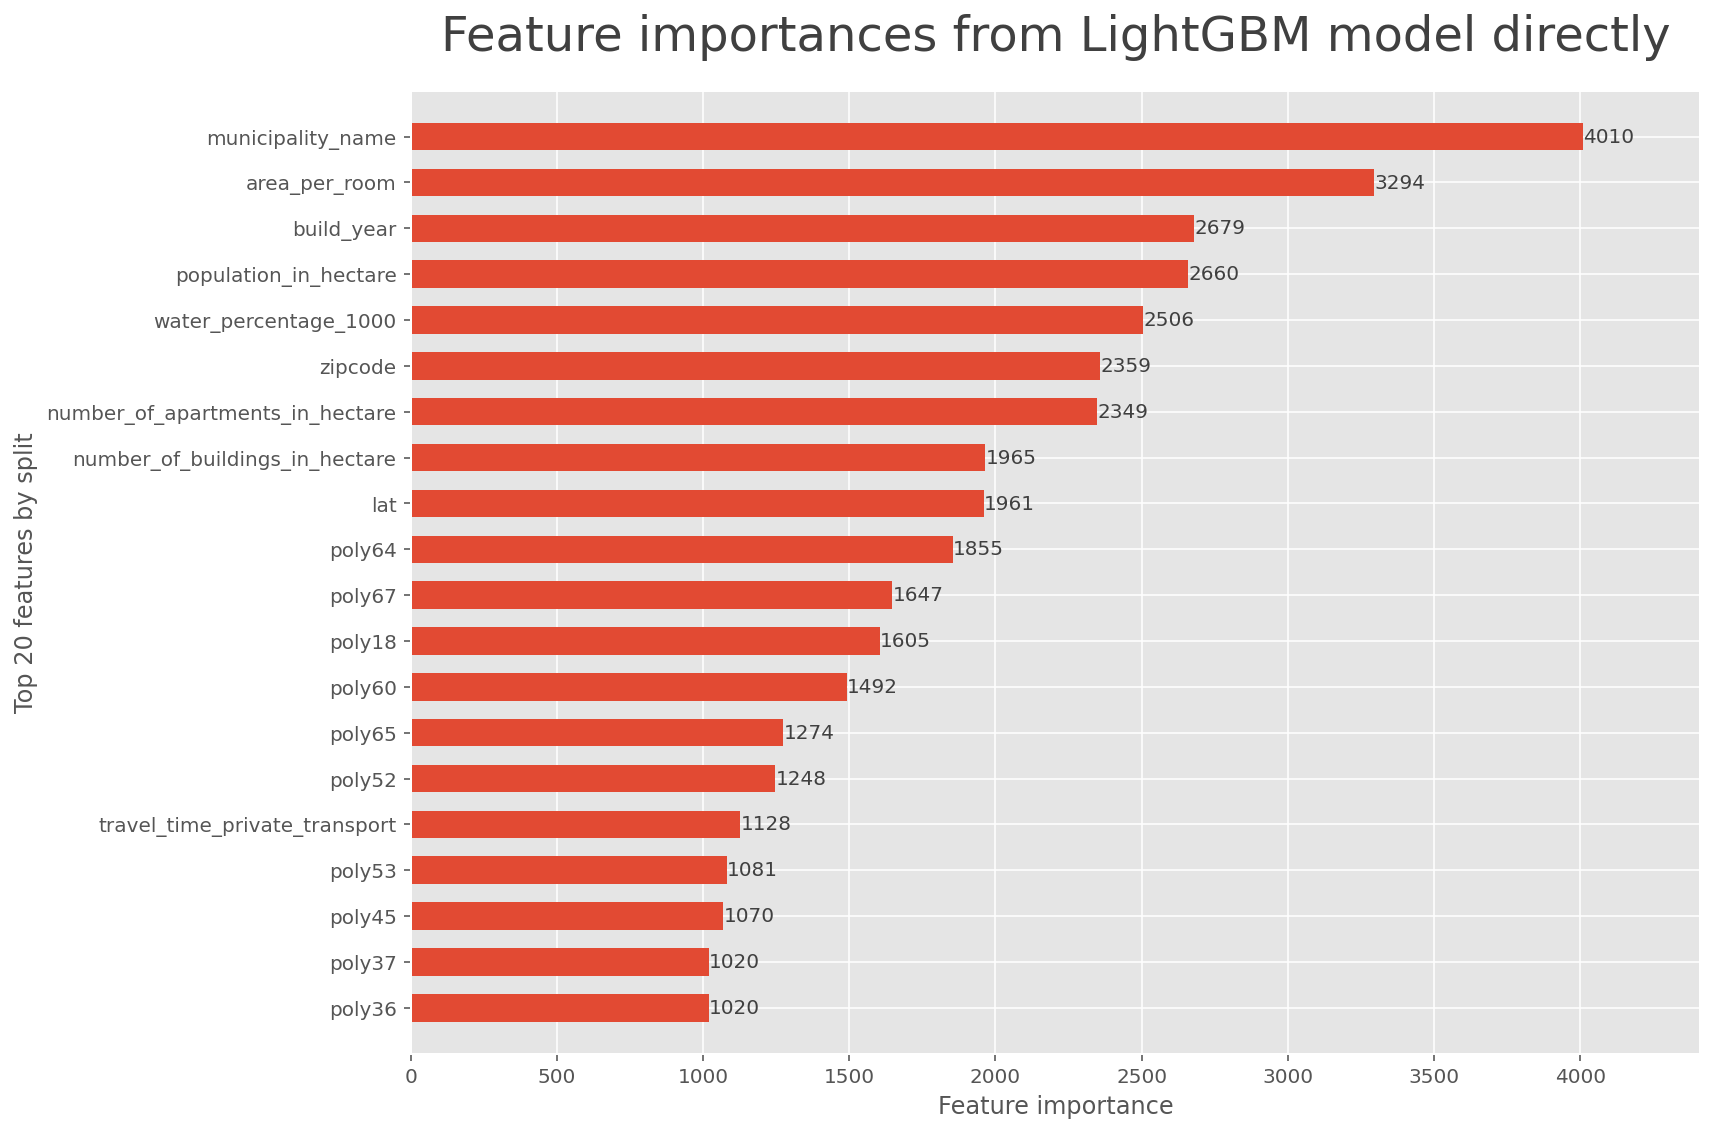

In [22]:
lgb.plot_importance(pipe.steps[0][1],figsize=(12,8), 
                    importance_type="split", 
                    max_num_features=20, 
                    height=0.6
                   )
plt.title("Feature importances from LightGBM model directly", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.ylabel("Top 20 features by split")
plt.tight_layout()
plt.show()

In [23]:
%%time
result = permutation_importance(pipe, 
                                X, 
                                np.log(y),
                                scoring="neg_mean_absolute_percentage_error", 
                                n_repeats=1,
                                random_state=0)

CPU times: user 7min 23s, sys: 11.3 s, total: 7min 34s
Wall time: 1min 1s


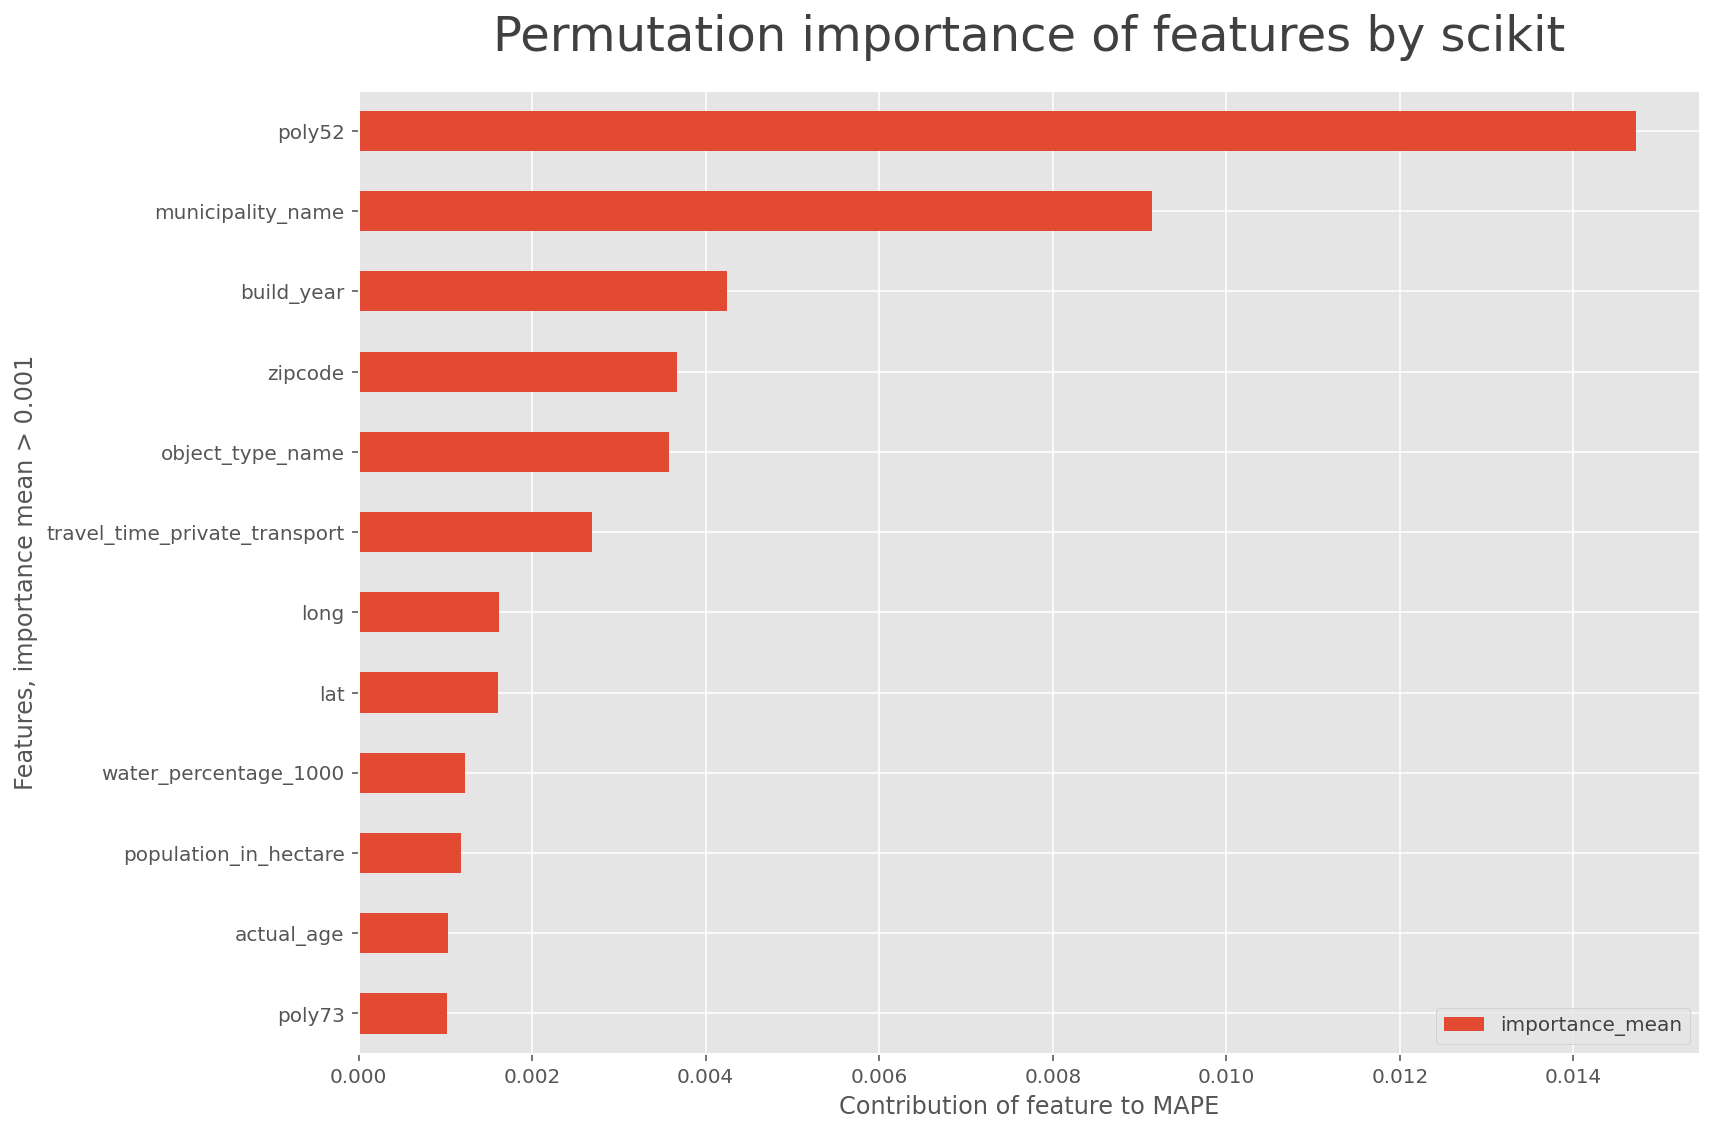

In [24]:
cut_off = 0.001
df_results = pd.DataFrame(result["importances_mean"])
df_results.columns = ["importance_mean"]
df_results = df_results[df_results["importance_mean"] > cut_off]
df_results.sort_values(by="importance_mean", ascending=True, inplace=True)
feature_labels = df_train.drop("id", axis=1).columns[df_results.index]

df_results.plot.barh(figsize=(12,8))
plt.yticks(ticks=range(0, len(df_results)), labels=feature_labels)
plt.title("Permutation importance of features by scikit", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.ylabel(f"Features, importance mean > {cut_off}")
plt.xlabel("Contribution of feature to MAPE")
plt.tight_layout()
plt.show()

# 4) Additional data

To further improve the scoring I bring in additional data of municipalities taken from [here](https://www.bfs.admin.ch/bfs/de/home/statistiken/regionalstatistik/regionale-portraets-kennzahlen/gemeinden.assetdetail.7786544.html).

In [25]:
df, df_train, df_test = prepare_data()

X = df_train.drop(["id", "price"], axis=1)
y = df_train.price

In [26]:
dfx = pd.read_excel("_data/regionalportraits_2019.xls")

# Prepare additional data
dfx.columns = dfx.columns.str.lower().str.replace(" ", "_").str.strip()
dfx.drop("gemeindecode", axis=1, inplace=True)
dfx.replace("*", np.nan, inplace=True)
dfx.replace("X", np.nan, inplace=True)

# Rename some locations to match municipality names in given data
dfx.replace("Mollens (VD)", "Mollens (VS)", inplace=True)
dfx.replace("Estavayer", "Estavayer-le-Lac", inplace=True)
dfx.replace("Cheyres-Châbles", "Cheyres", inplace=True)
dfx.replace("Bergün Filisur", "Bergün/Bravuogn", inplace=True)
df.replace("Filisur", "Bergün/Bravuogn", inplace=True)
cols = ["beschäftigte_total", "im_1._sektor", "im_2._sektor", "im_3._sektor", 
        "arbeitsstätten_total", "im_1._sektor.1", "im_2._sektor.1", "im_3._sektor.1"]
dfx[cols] = dfx[cols].astype(float)

# Merge given and additional data by municipality
df_ext = pd.merge(df, dfx, left_on="municipality_name", right_on="gemeindename", how="left")
df_ext.drop("gemeindename", axis=1, inplace=True)

# Calculate number of samples for which no matching extended data is available
not_matched = len(df_ext[df_ext.isna().sum(axis=1) > 40].municipality_name.values)
print(f"For {not_matched} properties the data can not be extended.")

# Label encode categoricals
l_enc = LabelEncoder()
df_ext.municipality_name = l_enc.fit_transform(df_ext.municipality_name)

l_enc = LabelEncoder()
df_ext.object_type_name = l_enc.fit_transform(df_ext.object_type_name)

# Split extended data into train and test set
dfx_train = df_ext[df_ext.price.notna()].copy()
dfx_test  = df_ext[df_ext.price.isna()].copy().reset_index(drop=True)

For 132 properties the data can not be extended.


In [27]:
X = dfx_train.drop(["id", "price"], axis=1)
y = dfx_train.price

pipe = Pipeline([('clf', lgb.LGBMRegressor(n_jobs=-1,  
                                           n_estimators=3000,
                                           learning_rate=0.037, 
                                          ))])

_ = pipe.fit(X, np.log(y))
create_submission_extended_data(pipe, X, np.log(y), file_name=f"submission_extended_data.csv")

# 16.94938 - private
# 17.55465 - public

Submission saved.
